In [78]:
import pandapower as pp

import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

from solution_files_manager import SolutionFilesManager
from opt_utils import *
from opf_utils import *

In [79]:
import os
folder = os.path.abspath(os.getcwd())

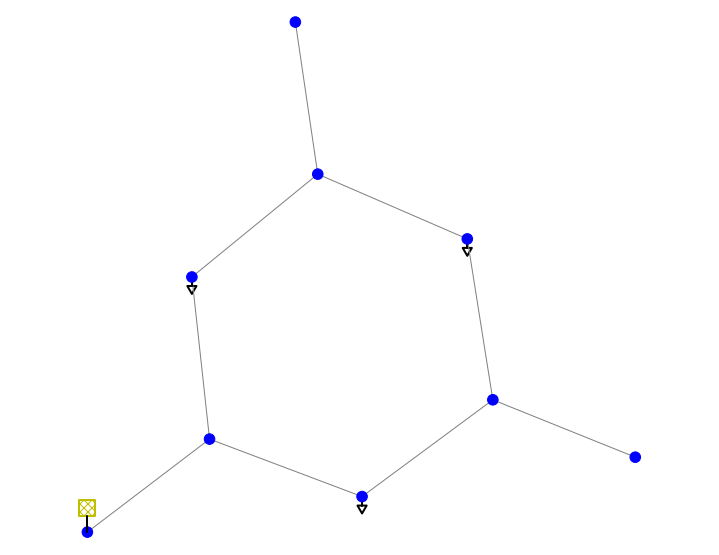

In [80]:
case = "case9"
net, n, gen_df, n_gen, gens, load_df, graph, G_val, B_val, Y_val = load_pp_network(case)

## Variables & parameters

In [81]:
X = cp.Variable((n,n), hermitian=True)

In [82]:
p_d_val = load_df[["p_mw"]].to_numpy() / net.sn_mva
q_d_val = load_df[["q_mvar"]].to_numpy() / net.sn_mva

In [83]:
# loads
p_d = cp.Parameter((n,1), nonneg=True, value=p_d_val)
q_d = cp.Parameter((n,1), value=q_d_val)

# admittance matrices
G = cp.Parameter((n,n), symmetric=True, value=G_val)
B = cp.Parameter((n,n), symmetric=True, value=B_val)
Y = cp.Parameter((n,n), complex=True, value=Y_val)

# squares of voltage bounds
V_min_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["min_vm_pu"].to_numpy()))
V_max_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["max_vm_pu"].to_numpy()))

# bounds for generated power
p_min = cp.Parameter((n_gen,1), value=gen_df[["min_p_mw"]].to_numpy() / net.sn_mva)
p_max = cp.Parameter((n_gen,1), value=gen_df[["max_p_mw"]].to_numpy() / net.sn_mva)
q_min = cp.Parameter((n_gen,1), value=gen_df[["min_q_mvar"]].to_numpy() / net.sn_mva)
q_max = cp.Parameter((n_gen,1), value=gen_df[["max_q_mvar"]].to_numpy() / net.sn_mva)

In [84]:
# vectors of cost coefficients: c_[p or q]_[power]
# costs are only on generators

c_p_2 = cp.Parameter((n_gen), value=gen_df["cp2_eur_per_mw2"].to_numpy() * (net.sn_mva**2), nonneg=True)
c_p_1 = cp.Parameter((n_gen), value=gen_df["cp1_eur_per_mw"].to_numpy() * net.sn_mva, nonneg=True)
c_p_0 = cp.Parameter((n_gen), value=gen_df["cp0_eur"].to_numpy(), nonneg=True)

c_q_2 = cp.Parameter((n_gen), value=gen_df["cq2_eur_per_mvar2"].to_numpy() * (net.sn_mva**2), nonneg=True)
c_q_1 = cp.Parameter((n_gen), value=gen_df["cq1_eur_per_mvar"].to_numpy() * net.sn_mva, nonneg=True)
c_q_0 = cp.Parameter((n_gen), value=gen_df["cq0_eur"].to_numpy(), nonneg=True)

In [85]:
Phis = []
Psis = []
for i in range(n):
    J_i = np.zeros((n,n))
    J_i[i][i] = 1
    Y_i = J_i @ Y_val
    Phi_i = 1 / 2 * (Y_i.conj().T + Y_i)
    Phis.append(Phi_i)
    Psi_i = 1 / 2j * (Y_i.conj().T - Y_i)
    Psis.append(Psi_i)

## SDP (QCQP)

In [86]:
constraints = [ X >> 0 ]

for i in range(n):
    if i in gens:
        i_gen_idx = gens.index(i)
        constraints += [ cp.real(cp.trace(Phis[i] @ X)) + p_d[i] <= p_max[i_gen_idx] ]
        constraints += [ cp.real(cp.trace(Phis[i] @ X)) + p_d[i] >= p_min[i_gen_idx] ]
        constraints += [ cp.real(cp.trace(Psis[i] @ X)) + q_d[i] <= q_max[i_gen_idx] ]
        constraints += [ cp.real(cp.trace(Psis[i] @ X)) + q_d[i] >= q_min[i_gen_idx] ]
    else:
        constraints += [ cp.real(cp.trace(Phis[i] @ X)) == -p_d[i] ]
        constraints += [ cp.real(cp.trace(Psis[i] @ X)) == -q_d[i] ]

constraints += [
    cp.real(cp.diag(X)) >= V_min_sq,
    cp.real(cp.diag(X)) <= V_max_sq
]

In [87]:
# the power generation costs are not dpp but can be modified
p_cost = cp.sum([ c_p_2[i] * cp.square((cp.real(cp.trace(Phis[gens[i]] @ X)) + p_d[gens[i]])) + c_p_1[i] * (cp.real(cp.trace(Phis[gens[i]] @ X)) + p_d[gens[i]]) for i in range(n_gen) ]) + cp.sum(c_p_0)
q_cost = cp.sum([ c_q_2[i] * cp.square((cp.real(cp.trace(Psis[gens[i]] @ X)) + p_d[gens[i]])) + c_q_1[i] * (cp.real(cp.trace(Psis[gens[i]] @ X)) + q_d[gens[i]]) for i in range(n_gen) ]) + cp.sum(c_q_0)

# loss_cost = cp.sum([ cp.sum([ G[i][j] * cp.real(X[i][i] + X[j][j] - X[i][j] - X[j][i]) for j in range(i)]) for i in range(n)])

In [88]:
# power generation cost
prob = cp.Problem(cp.Minimize(p_cost + q_cost), constraints)

# line loss
# prob = cp.Problem(cp.Minimize(loss_cost), constraints)

In [89]:
# prob.solve(solver=cp.SCS, verbose=True)
# prob.solve(solver=cp.CVXOPT, verbose=True)
prob.solve(solver=cp.MOSEK, verbose=True)

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Jul 11 02:56:31 PM: Your problem has 81 variables, 27 constraints, and 66 parameters.
(CVXPY) Jul 11 02:56:31 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 11 02:56:31 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 11 02:56:31 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Jul 11 02:56:31 PM: Reduction chain: EvalParams -> Complex2Real -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> MOSEK
(CVXPY) Jul 11 02:56:31 PM: Applying reduction EvalParams
(CVXPY) Jul 11 02:56:31 PM: Applyi

/home/ivanightingale/miniconda3/envs/convex/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


5296.685974977402

In [90]:
np.linalg.eigvalsh(prob.constraints[0].dual_variables[0].value)

array([5.04832146e-07, 2.98777256e-04, 4.20408249e-04, 2.18573794e+00,
       1.52934400e+03, 1.91070289e+03, 4.66735409e+03, 5.70675560e+03,
       7.36862963e+03])

In [42]:
np.linalg.eigvalsh(X.value)

array([-5.67802702e-09, -5.54018297e-09, -5.30888180e-09, -4.57511510e-09,
       -5.95607626e-10,  7.45606428e-06,  3.12977018e-03,  1.63930042e-02,
        1.07262972e+01])

In [43]:
X_val = X.value

### Interior point computation

In [44]:
prob_center = cp.Problem(cp.Maximize( cp.log_det(X)
                                     + cp.sum([ cp.log(p_max[i] - cp.real(cp.trace(Phis[gens[i]] @ X)) - p_d[gens[i]]) + cp.log(cp.real(cp.trace(Phis[gens[i]] @ X)) + p_d[gens[i]] - p_min[i]) for i in range(n_gen) ])
                                     + cp.sum([cp.log(q_max[i] - cp.real(cp.trace(Psis[gens[i]] @ X)) - q_d[gens[i]]) + cp.log(cp.real(cp.trace(Psis[gens[i]] @ X)) + q_d[gens[i]] - q_min[i]) for i in range(n_gen) ])
                                     + cp.sum([ cp.log(V_max_sq[i] - cp.real(X[i][i])) + cp.log(cp.real(X[i][i]) - V_min_sq[i]) for i in range(n) ]) ), constraints)

prob_center.solve(solver=cp.SCS, verbose=True)
# prob_center.solve(solver=cp.MOSEK, verbose=True)

                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) Jul 11 02:34:01 PM: Your problem has 81 variables, 27 constraints, and 48 parameters.
(CVXPY) Jul 11 02:34:01 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 11 02:34:01 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 11 02:34:01 PM: Compiling problem (target solver=SCS).
(CVXPY) Jul 11 02:34:01 PM: Reduction chain: Complex2Real -> FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Jul 11 02:34:01 PM: Applying reduction Complex2Real
(CVXPY) Jul 11 02:34:01 PM: Apply

-50.25732551788209

In [45]:
X_center = X.value

### Fixed point iterations

In [46]:
X.value = X_val
X_path = fixed_point_iteration(prob, X, -X_center, True, True, 1e-3, True)

initial objective: 5296.685975
initial eigenvalues:
[-5.67802702e-09 -5.54018297e-09 -5.30888180e-09 -4.57511510e-09
 -5.95607626e-10  7.45606428e-06  3.12977018e-03  1.63930042e-02
  1.07262972e+01]
current objective: 6302.678209
current eigenvalues:
[-1.99400577e-09 -1.84150862e-10  1.49331061e-09  7.18074176e-09
  9.02106556e-09  1.60656617e-08  3.84832625e-07  1.25823567e-02
  1.07635182e+01]
current objective: 6345.912716
current eigenvalues:
[-1.89532649e-09 -2.53776724e-10  1.01371580e-09  5.79707444e-09
  1.28971704e-08  3.25655263e-08  2.08075580e-07  1.19065571e-02
  1.07639656e+01]
fixed point objective: 6347.375444
fixed point eigenvalues:
[-1.72555492e-09 -2.60640194e-10  8.62520062e-10  5.10620509e-09
  1.14222053e-08  3.09058986e-08  2.02808049e-07  1.18793886e-02
  1.07639812e+01]
iterations:  3


In [47]:
X_fixed_point = X.value

In [73]:
# X.value = X_val
# recover_verify_solution(prob, X)

7.95572765938431e-16
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[3.038077e-06]
[1.12352153e-06]
[0.00020222]
[6.75180706e-05]
[0.00157713]
[0.03464934]
[0.00022471]
[7.87897255e-05]
[0.00045975]
[0.00628828]
[0.00028084]
[0.00011251]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
<bound method PSD.name of PSD(Expression(AFFINE, UNKNOWN, (9, 9)))>
<bound method Inequality.name of Inequality(Expression(AFFINE, UNKNOWN, (1,)))>
<bound method Inequality.name of Inequality(Expression(CONSTANT, UNKNOWN, (1,)))>
<bound method Inequality.name of Inequality(Expression(AFFINE, UNKNOWN, (1,)))>
<bound method Inequality.name of Inequality(Expression(CONSTANT, UNKNOWN, (1,)))>
<bound method Inequality.name of Inequality(Expression(AFFINE, UNKNOWN, (1,)))>
<bound method Inequality.name of Inequality(Expression(CONSTANT, UNKNOWN, (1,)))>
<bound method Inequality.name of Inequality(Expression(AFFINE, UNKNOWN, (1,)))>
<bound method Inequality.name of Inequality(Expression(CO

### Load pandapower local solution

In [48]:
sfm = SolutionFilesManager(folder, case, "pp")
a = sfm.load_solution()
v = a[1]
X_pp = np.outer(v, v.conj())

## SDP sampling

In [49]:
C = cp.Parameter((n,n), hermitian=True)
sampling_prob = cp.Problem(cp.Minimize(cp.real(cp.trace(C @ X))), constraints)

In [50]:
sample_file_path = folder + "/solutions/" + case + "/samples.npy"

In [51]:
# X_samples = np.array([])

In [52]:
X_samples = np.load(sample_file_path)

In [53]:
rng = np.random.default_rng()

In [94]:
sampling_iter = 1000
X_new_samples = [[]] * sampling_iter

for i in range(sampling_iter):
    # generate random Hermitian matrix value for C
    A = rng.uniform(-1, 1, (n,n)) + rng.uniform(-1, 1, (n,n)) * 1j
    C.value = A.conj().T + A
    sampling_prob.solve()
    X_new_samples[i] = X.value

if len(X_samples) == 0:
    X_samples = np.array(X_new_samples)
else:
    X_samples = np.append(X_samples, np.array(X_new_samples), axis=0)

In [95]:
np.save(sample_file_path, X_samples)

## Plotting

\begin{equation*}
\begin{pmatrix}
\Re(X) \\ \Im(X)
\end{pmatrix}
=
\begin{pmatrix}
0 & 1 & 2 & ... & n-1 \\
  & n & n+1 & ... & 2n-2 \\
  &   & \ddots &  & \vdots \\
  &   &       &   & \frac{n^{2} + n}{2} - 1  \\
  & \frac{n^{2} + n}{2} & \frac{n^{2} + n}{2} + 1 & ... & \frac{n^{2}}{2} + (n - 2) \\
  & & \ddots & & \vdots \\
  & & & & n^{2} - 1
\end{pmatrix}
\end{equation*}

In [97]:
i = 0
j = 1
x_data_part = np.real

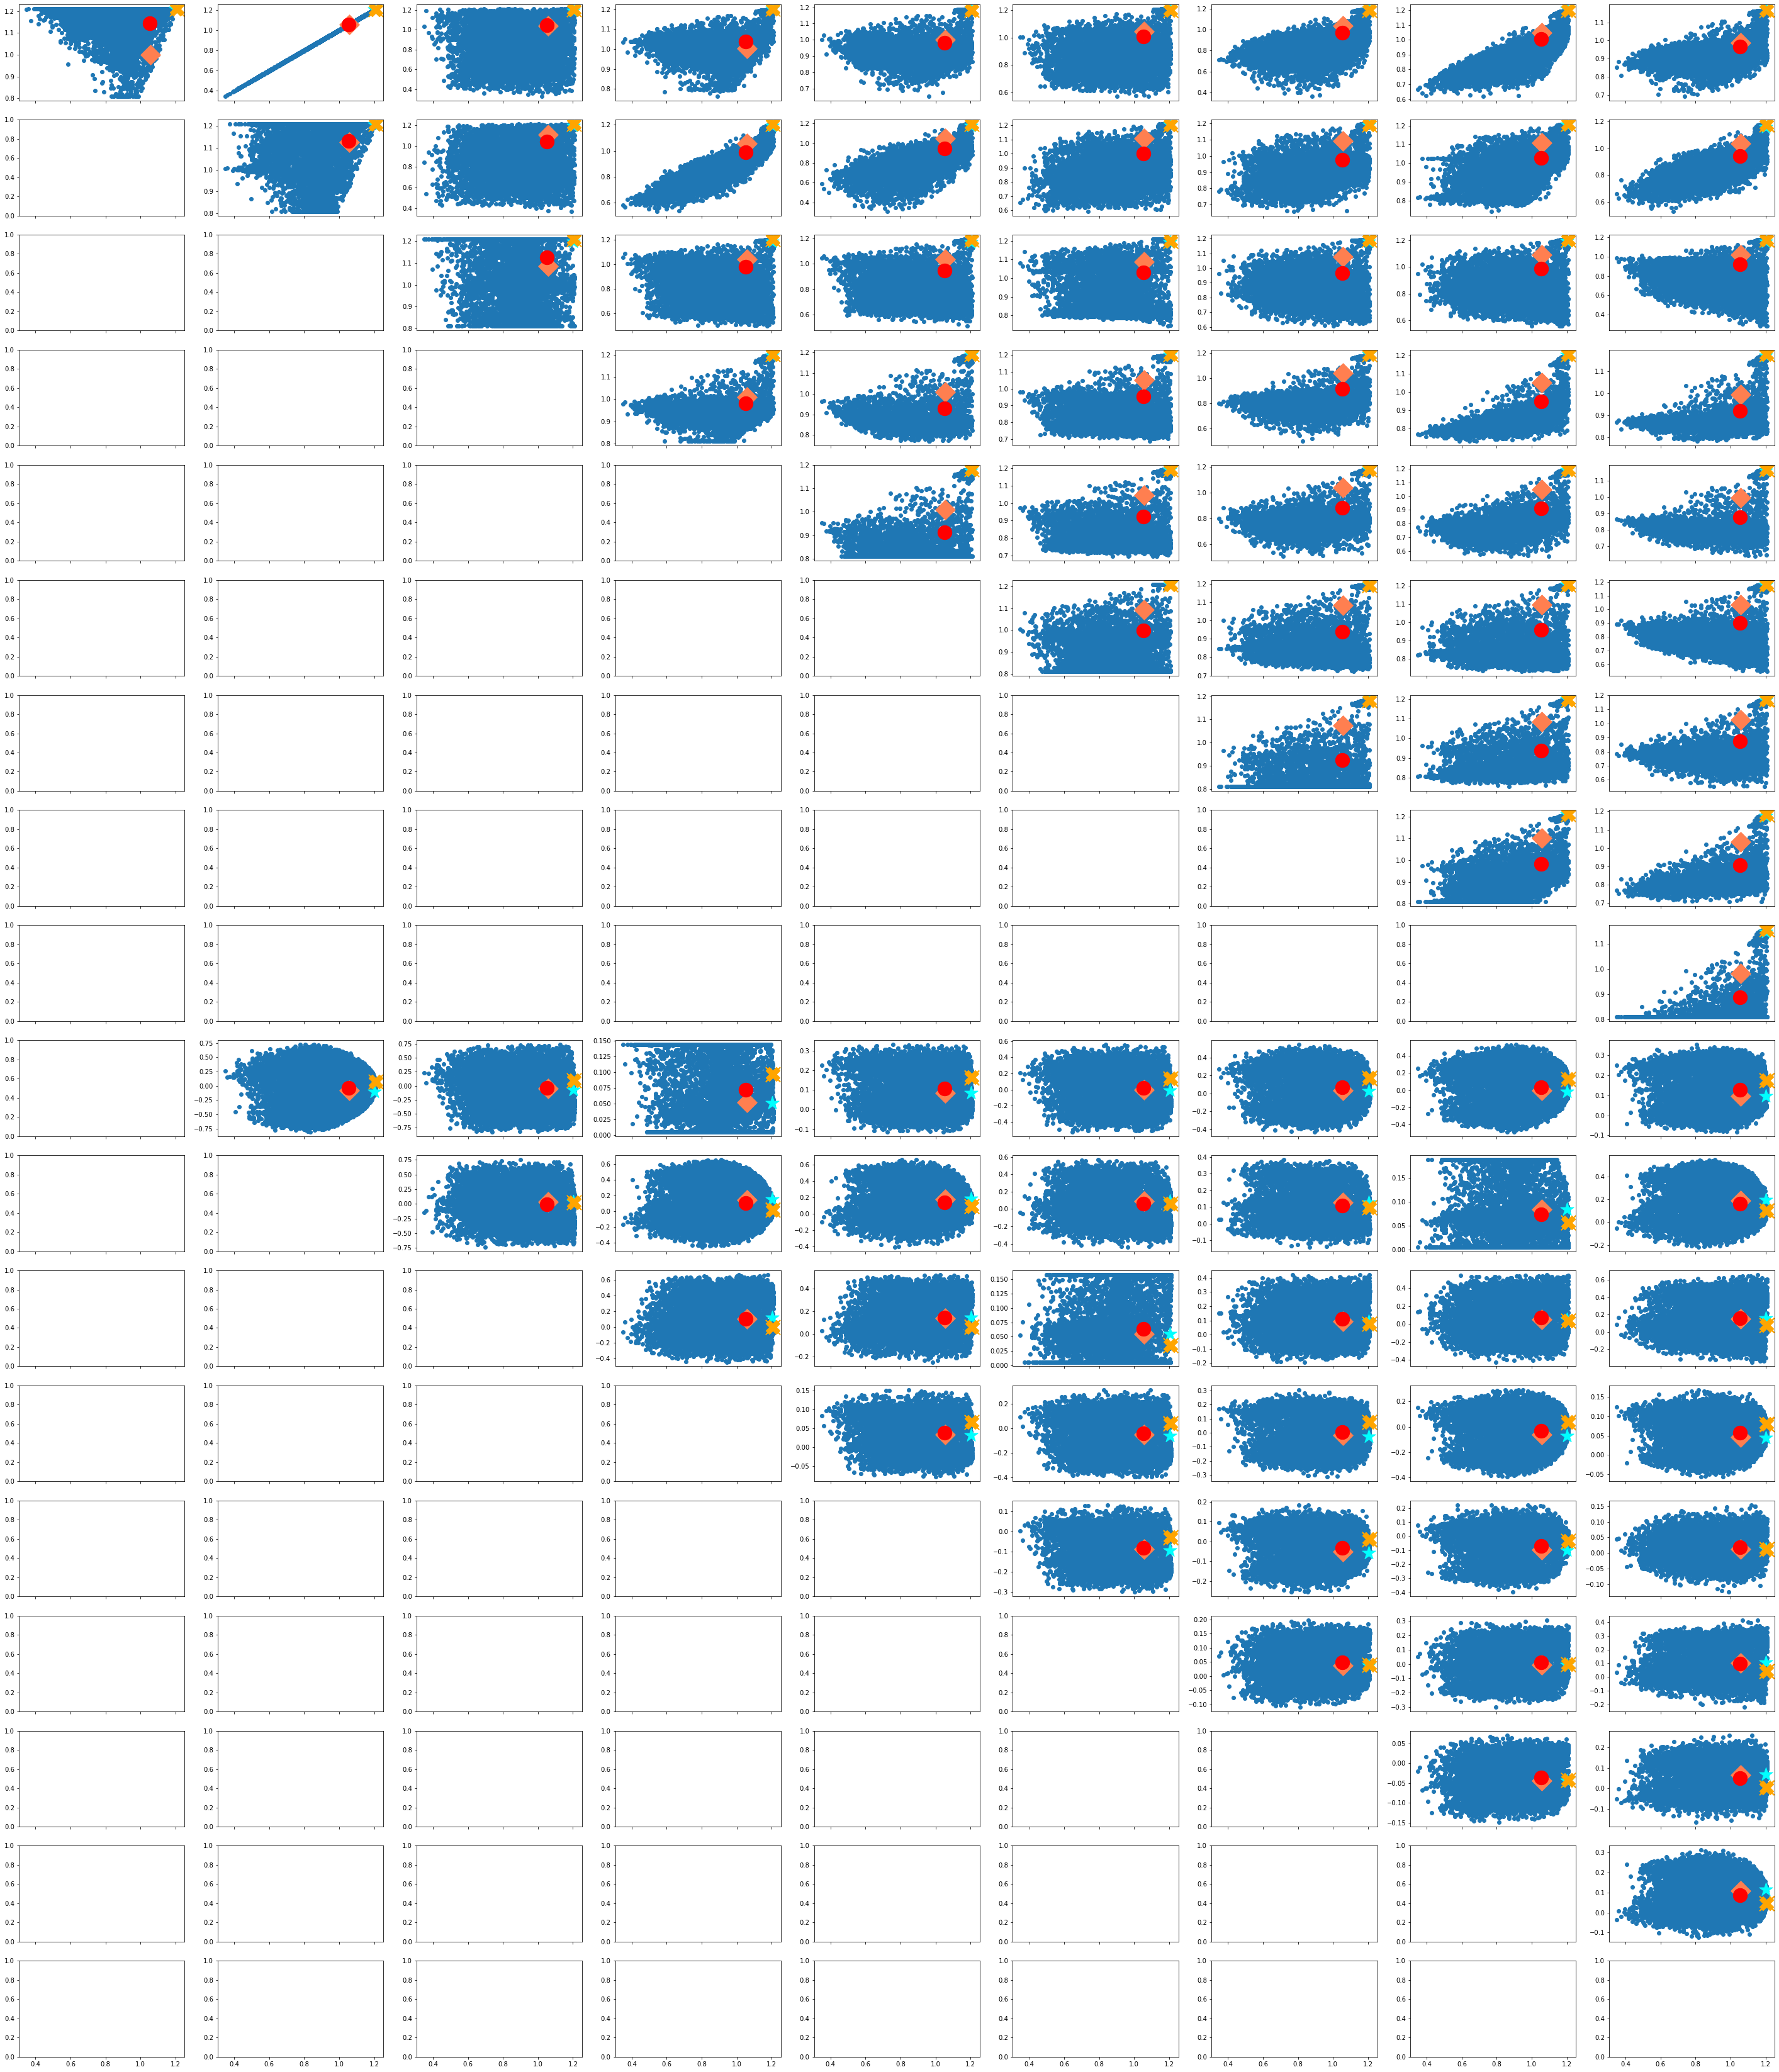

In [98]:
fig, axs = plt.subplots(2 * n, n, figsize=(50, 60), sharex=True)

for c in range(n):
    for r in range(c + 1):
        axs[r, c].scatter(x_data_part(X_samples[:, i, j]), np.real(X_samples[:, r, c]))
        axs[r, c].scatter(x_data_part(X_pp[i, j]), np.real(X_pp[r, c]), c="coral", s=5e2, marker="D")
        axs[r, c].scatter(x_data_part(X_val[i, j]), np.real(X_val[r, c]), c="aqua", s=5e2, marker="*")
        axs[r, c].scatter(x_data_part(X_center[i, j]), np.real(X_center[r, c]), c="red", s=5e2, marker="o")
        axs[r, c].scatter(x_data_part(X_fixed_point[i, j]), np.real(X_fixed_point[r, c]), c="orange", s=5e2, marker="X")
        axs[r, c].scatter(x_data_part(X_path[:, i, j]), np.real(X_path[:, r, c]), c="orange", s=5e2, marker="x")
for c in range(1, n):
    for r in range(c):
        axs[n + r, c].scatter(x_data_part(X_samples[:, i, j]), np.imag(X_samples[:, r, c]))
        axs[n + r, c].scatter(x_data_part(X_pp[i, j]), np.imag(X_pp[r, c]), c="coral", s=5e2, marker="D")
        axs[n + r, c].scatter(x_data_part(X_val[i, j]), np.imag(X_val[r, c]), c="cyan", s=5e2, marker="*")
        axs[n + r, c].scatter(x_data_part(X_center[i, j]), np.imag(X_center[r, c]), c="red", s=5e2, marker="o")
        axs[n + r, c].scatter(x_data_part(X_fixed_point[i, j]), np.imag(X_fixed_point[r, c]), c="orange", s=5e2, marker="X")
        axs[n + r, c].scatter(x_data_part(X_path[:, i, j]), np.imag(X_path[:, r, c]), c="orange", s=5e2, marker="x")

In [58]:
net.bus

,in_service,max_vm_pu,min_vm_pu,name,type,vn_kv,zone
0,True,1.1,0.9,1,b,345.0,1.0
1,True,1.1,0.9,2,b,345.0,1.0
2,True,1.1,0.9,3,b,345.0,1.0
3,True,1.1,0.9,4,b,345.0,1.0
4,True,1.1,0.9,5,b,345.0,1.0
5,True,1.1,0.9,6,b,345.0,1.0
6,True,1.1,0.9,7,b,345.0,1.0
7,True,1.1,0.9,8,b,345.0,1.0
8,True,1.1,0.9,9,b,345.0,1.0
